# Performance Comparison of SHA-256, Blake2b, Blake2s, Blake3 and RSA.

### Author: labry (Justin Park)

## A way to generate an RSA public key pair
openssl genpkey -algorithm RSA -out labry_private.pem -pkeyopt rsa_keygen_bits:2048\
openssl rsa -pubout -in labry_private.pem -out labry_public.pem

In [10]:
from hashcompare import Hash
from hashlib import sha1, sha256, blake2b, blake2s
from blake3 import blake3, KEY_LEN, OUT_LEN
from zlib import crc32
import time
import inspect
import numpy as np
import copy

In [11]:
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import padding
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.serialization import load_pem_private_key
from cryptography.hazmat.primitives.serialization import load_pem_public_key

In [12]:
class RSA_Hash():
    
    def __init__(self, name):
        self.labryPubKey = load_pem_public_key(
            open('/Users/labry/Downloads/labry_public.pem','rb').read(),
            default_backend())
        
        self.name = name
        self.sha = sha256()
        
    def update(self, data):
        self.sha.update(data)
        self.packet = self.sha.digest()
        #self.packet = data
        
    def digest(self):
            self.ciphertext = self.labryPubKey.encrypt(
                self.packet,
                padding.OAEP(
                    mgf=padding.MGF1(algorithm=hashes.SHA256()),
                    algorithm=hashes.SHA256(),
                    label=None
                )
            )
            return self.ciphertext 

In [13]:
x_range = [1,10,20,30,40,50,60,70,80,90, 100, 110]
#x_range = [15]
names_of_hashes = ['sha256','blake2b','blake2s','rsa-sha256','blake3']

rsa = RSA_Hash("rsa-sha256")
hash_mapper = [Hash(sha256(),names_of_hashes[0]), Hash(blake2b(),names_of_hashes[1]),
               Hash(blake2s(),names_of_hashes[2]), Hash(rsa,names_of_hashes[3]),Hash(blake3(),names_of_hashes[4])]
hash_mapper = np.array(hash_mapper)

simulated_packet = "abcdefghij"
packet= []

for weight in x_range:
    packet.append(simulated_packet * weight)
    
for idx, hash_f in enumerate(hash_mapper):

    for i in range(len(x_range)):
        hash_mapper[idx].set_start(time.time())
        for j in range(Hash.NUM_OF_ROUNDS):
            #packet = simulated_packet*i
            hash_f.update(packet[i].encode())
            hash_v = hash_f.digest()

        hash_mapper[idx].set_finish(time.time())

    print("{} {} performed {} operations in {} {} \n".format
        (idx, hash_mapper[idx].get_name(), Hash.NUM_OF_ROUNDS,  len(hash_mapper[idx].get_duration()), hash_mapper[idx].get_duration()))

0 sha256 performed 10000 operations in 12 [0.032198190689086914, 0.026971101760864258, 0.022413015365600586, 0.02551889419555664, 0.02880406379699707, 0.03408408164978027, 0.03714919090270996, 0.03992199897766113, 0.06232619285583496, 0.09192085266113281, 0.09985923767089844, 0.10504484176635742] 

1 blake2b performed 10000 operations in 12 [0.02433300018310547, 0.025586843490600586, 0.02651190757751465, 0.029154062271118164, 0.03258228302001953, 0.041510820388793945, 0.04520583152770996, 0.04720592498779297, 0.04998898506164551, 0.05456209182739258, 0.05184602737426758, 0.054511070251464844] 

2 blake2s performed 10000 operations in 12 [0.01966381072998047, 0.020390033721923828, 0.021562814712524414, 0.024146080017089844, 0.029199838638305664, 0.03568291664123535, 0.03810572624206543, 0.04130101203918457, 0.029169082641601562, 0.030022144317626953, 0.03057408332824707, 0.0331728458404541] 

3 rsa-sha256 performed 10000 operations in 12 [0.8257291316986084, 1.3393421173095703, 1.019731

In [5]:
default_duration = np.array(hash_mapper[0].get_duration())

import pandas as pd
import matplotlib.pyplot as plt
default_duration = pd.DataFrame(default_duration)

       sha256   blake2b   blake2s  rsa-sha256    blake3
1    0.032198  0.024333  0.019664    0.825729  0.028587
10   0.026971  0.025587  0.020390    1.339342  0.031264
20   0.022413  0.026512  0.021563    1.019732  0.033293
30   0.025519  0.029154  0.024146    1.080861  0.034795
40   0.028804  0.032582  0.029200    1.359787  0.036724
50   0.034084  0.041511  0.035683    0.862748  0.043268
60   0.037149  0.045206  0.038106    1.500576  0.044838
70   0.039922  0.047206  0.041301    1.190538  0.043784
80   0.062326  0.049989  0.029169    1.075788  0.045243
90   0.091921  0.054562  0.030022    0.919702  0.046484
100  0.099859  0.051846  0.030574    1.257686  0.049264
110  0.105045  0.054511  0.033173    1.177890  0.050025


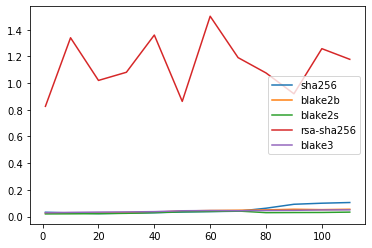

In [19]:

#print(len(x_range))
zero_data = np.zeros(shape=(len(names_of_hashes),1))
zero_series = pd.Series(zero_data[:,0])
#print(zero_series)
plot_result2 = pd.DataFrame({names_of_hashes[0]: zero_series, names_of_hashes[1]: zero_series,
                   names_of_hashes[2]: zero_series}, index=x_range)

#print(plot_result2)
for idx, hash_f in enumerate(hash_mapper):
    plot_result2[names_of_hashes[idx]] = np.array(hash_mapper[idx].get_duration()[0])
    #print(hash_mapper[idx].get_duration())

plot_result2.plot()
print(plot_result2)    


In [7]:
com_result = pd.DataFrame(columns=names_of_hashes[0:-1])

print(hash_mapper[0].get_duration())
print(hash_mapper[1].get_duration())
print(hash_mapper[2].get_duration())
print(hash_mapper[3].get_duration())
temp = hash_mapper[3].get_duration()[0]/hash_mapper[0].get_duration()[0]
com_result[names_of_hashes[0]] = temp

temp = hash_mapper[3].get_duration()[0]/hash_mapper[1].get_duration()[0]
com_result[names_of_hashes[1]] = temp

temp = hash_mapper[3].get_duration()[0]/hash_mapper[2].get_duration()[0]
com_result[names_of_hashes[2]] = temp

com_result

[0.03492093086242676, 0.04262399673461914, 0.05767989158630371, 0.2093048095703125, 0.03448605537414551, 0.03393816947937012, 0.037396907806396484, 0.07163715362548828, 0.0814509391784668, 0.08415484428405762, 0.0860440731048584, 0.09144210815429688]
[0.021759986877441406, 0.023324966430664062, 0.026835918426513672, 0.03128314018249512, 0.03271818161010742, 0.03323721885681152, 0.02430415153503418, 0.025956153869628906, 0.027947187423706055, 0.02990412712097168, 0.029449939727783203, 0.03142380714416504]
[0.010972261428833008, 0.013071775436401367, 0.014528036117553711, 0.016709089279174805, 0.01792287826538086, 0.022686004638671875, 0.024145841598510742, 0.02575206756591797, 0.02691197395324707, 0.029470205307006836, 0.031036853790283203, 0.033177852630615234]
[1.082360029220581, 0.8299746513366699, 1.4576208591461182, 0.9469389915466309, 1.2430148124694824, 1.2276709079742432, 0.9618871212005615, 1.3870792388916016, 0.9102389812469482, 1.2260050773620605, 1.4247102737426758, 0.902477

,sha256,blake2b,blake2s,rsa-sha256


In [17]:
plot_result = pd.DataFrame(columns=names_of_hashes)
relative_performance = {}
for idx, hash_f in enumerate(hash_mapper):
    hash_mapper[idx].duration = pd.DataFrame(hash_mapper[idx].get_duration())
    hash_mapper[idx].duration.name = hash_mapper[idx].get_name()

    relative_performance.update({idx: hash_mapper[idx].get_duration()/default_duration})
    alist = []
    for item in relative_performance[idx].values:
        alist.append(item)
    col_name = hash_mapper[idx].get_name()
    data = pd.Series(alist,name=col_name)
    plot_result[col_name] = data.astype(float)

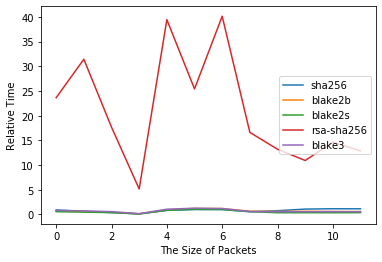

In [18]:
ax = plot_result.plot()
ax.set_xlabel("The Size of Packets")
ax.set_ylabel("Relative Time")
ax.legend(loc='center right')
plt.show()